In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 7.7 MB/s 


In [ ]:
import pandas as pd
import math
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
import random
import imblearn
from imblearn.over_sampling import SMOTE
from tqdm.auto import tqdm
import itertools
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def fill_missing_values(df, method):
  if method == 'mean':
    df.fillna(df.mean(), inplace=True)
  elif method == 'median':
    df.fillna(df.median(), inplace=True)
  elif method == 'mode':
    for column in df.columns:
      print(column)
      df[column].fillna(df[column].mode()[0], inplace=True)
  return df

# feature selection
def select_features(df, columns=None, no_of_columns=None):
  if columns:
    df = df[columns]
  return df

def get_df(orig_df, method, columns=None, no_of_columns=None):
  df = orig_df
  df = select_features(df, columns, no_of_columns)
  df = fill_missing_values(df, method)
  return df

# train_test_split
def tt_split(df, X_cols=None, y_col=None):
  train_df, test_df = train_test_split(df, test_size=0.2)
  X_train = np.array(train_df[X_cols])
  y_train = np.array(train_df[y_col])
  X_test = np.array(test_df[X_cols])
  y_test = np.array(test_df[y_col])
  return train_df, test_df, X_train, y_train, X_test, y_test

In [ ]:
file_path='/content/gdrive/MyDrive/Temporal_Data.csv'
df = pd.read_csv(file_path)
df = df[df.VISCODE=='bl']
df.drop_duplicates()
feature_column_names = ['CDRSB_bl', 'MMSE_bl', 'ADAS13_bl', 'FAQ_bl', 'MOCA_bl', 'RAVLT_learning_bl', 'PTEDUCAT', 'RAVLT_immediate_bl' , 'ADAS11_bl', 'AGE', 'RAVLT_perc_forgetting_bl', 'RAVLT_forgetting_bl']
predicted_class_names = ['DX_bl']
other_columns = ['RID', 'VISCODE']
fields = feature_column_names + predicted_class_names+other_columns

df = get_df(df, method='mode', columns=fields)
train_df, test_df, X_train, y_train, X_test, y_test = tt_split(df, feature_column_names, predicted_class_names[0])

labels = np.array(train_df[predicted_class_names[0]])
features = train_df.drop(predicted_class_names+other_columns, axis=1)
feature_list = list(features.columns)
features = np.array(features)
classes=np.array(sorted(list(set(labels))))


CDRSB_bl
MMSE_bl
ADAS13_bl
FAQ_bl
MOCA_bl
RAVLT_learning_bl
PTEDUCAT
RAVLT_immediate_bl
ADAS11_bl
AGE
RAVLT_perc_forgetting_bl
RAVLT_forgetting_bl
DX_bl
RID
VISCODE


In [ ]:
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

In [ ]:
len(features), len(labels), len(train_df)

(1389, 1389, 1389)

In [ ]:
def get_top_2_accuracy(y_pred_top_2, y_train):
    correct = 0
    for i in range(len(y_train)):
        if y_train[i] in list(y_pred_top_2[i]):
            correct += 1
    return correct / len(y_train)

def get_3_class_accuracy(y_pred, y_train):
    conversion = {'CN': 'CN', 'SMC': 'MCI', 'EMCI': 'MCI', 'LMCI': 'MCI', 'AD': 'AD'}
    correct = 0
    for i in range(len(y_train)):
        if conversion[y_train[i]] == conversion[y_pred[i]]:
            correct += 1
    return correct / len(y_train)

def get_top2_tp(class_name,y_true,y_top2_pred):
    tp=0
    for i in range(len(y_true)):
        if (y_true[i]==class_name)and(class_name in y_top2_pred[i]):
            tp+=1
    return tp

def get_top2_fp(class_name,y_true,y_top2_pred):
    fp=0
    for i in range(len(y_true)):
        if ((y_true[i] not in y_top2_pred[i])and(class_name in y_top2_pred[i])):
            fp+=1
    return fp

def get_top2_fn(class_name,y_true,y_top2_pred):
    fn=0
    for i in range(len(y_true)):
        if ((y_true[i]==class_name)and(class_name not in y_top2_pred[i])):
            fn+=1
    return fn

def get_pr(tp,fp):
    alpha=0
    if(tp+fp==0):
      alpha=0.000001
    return (tp+alpha)/(tp+fp+alpha)

def get_re(tp,fn):
    alpha=0
    if(tp+fn==0):
      alpha=0.000001
    return tp/(tp+fn)

In [ ]:
cls = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

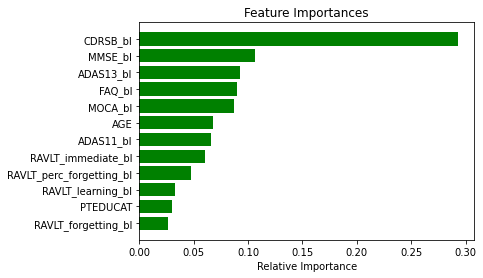

In [ ]:
importances = cls.feature_importances_
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.savefig('/content/gdrive/MyDrive/images/feature_importances.png', dpi=600)
plt.show()

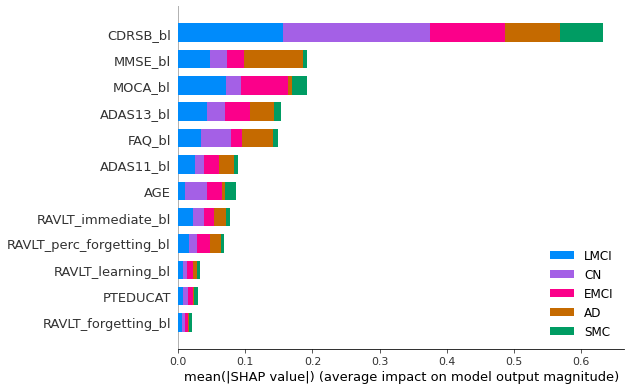

In [ ]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names= classes, feature_names = feature_column_names, show=False)
plt.savefig('/content/gdrive/MyDrive/images/shap_values.png', dpi=600)

In [ ]:
# shap_values

In [ ]:
feature_column_names

['CDRSB_bl',
 'MMSE_bl',
 'ADAS13_bl',
 'FAQ_bl',
 'MOCA_bl',
 'RAVLT_learning_bl',
 'PTEDUCAT',
 'RAVLT_immediate_bl',
 'ADAS11_bl',
 'AGE',
 'RAVLT_perc_forgetting_bl',
 'RAVLT_forgetting_bl']

In [ ]:
res=[None]*len(feature_column_names)
for n in tqdm(range(0, len(feature_column_names)), desc='number of features', leave=True):
  res[n] = dict()
  for ftrs in tqdm(findsubsets(feature_column_names, n+1), desc='features', leave=False):
    features = np.array(train_df[list(ftrs)])
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    y_pred_proba = cross_val_predict(clf, features, labels, cv=5, method='predict_proba')
    y_pred_top_2 = [classes[(-x).argsort()[:2]] for x in y_pred_proba]
    y_pred = [x[0] for x in y_pred_top_2]
    # accuracy = metrics.accuracy_score(labels, y_pred)
    top_2_accuracy = get_top_2_accuracy(y_pred_top_2, labels)
    accuracy_3_class = get_3_class_accuracy(y_pred, labels)
    cr = classification_report(y_true=labels, y_pred=y_pred, target_names=classes, output_dict=True)
    cr['top_2_acc'] = top_2_accuracy
    top2_tp=dict()
    top2_fp=dict()
    top2_fn=dict()
    top2_pr=dict()
    top2_re=dict()
    for class_name in classes:
      top2_tp[class_name]=get_top2_tp(class_name,labels,y_pred_top_2)
      top2_fp[class_name]=get_top2_fp(class_name,labels,y_pred_top_2)
      top2_fn[class_name]=get_top2_fn(class_name,labels,y_pred_top_2)
      top2_pr[class_name]=get_pr(top2_tp[class_name],top2_fp[class_name])
      top2_re[class_name]=get_re(top2_tp[class_name],top2_fn[class_name])
    cr['top_2_tp'] = top2_tp
    cr['top_2_fp'] = top2_fp
    cr['top_2_fn'] = top2_fn
    cr['top_2_pr'] = top2_pr
    cr['top_2_re'] = top2_re
    res[n][ftrs] = cr

number of features:   0%|          | 0/12 [00:00<?, ?it/s]

features:   0%|          | 0/12 [00:00<?, ?it/s]

features:   0%|          | 0/66 [00:00<?, ?it/s]

features:   0%|          | 0/220 [00:00<?, ?it/s]

features:   0%|          | 0/495 [00:00<?, ?it/s]

features:   0%|          | 0/792 [00:00<?, ?it/s]

features:   0%|          | 0/924 [00:00<?, ?it/s]

features:   0%|          | 0/792 [00:00<?, ?it/s]

features:   0%|          | 0/495 [00:00<?, ?it/s]

features:   0%|          | 0/220 [00:00<?, ?it/s]

features:   0%|          | 0/66 [00:00<?, ?it/s]

features:   0%|          | 0/12 [00:00<?, ?it/s]

features:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for i in range(len(feature_column_names)):
  print(len(res[i]))

12
66
220
495
792
924
792
495
220
66
12
1


In [ ]:
with open('/content/gdrive/MyDrive/cr3.npy', 'wb') as f:
  np.save(f, res)

In [ ]:
accs=dict()
stds=dict()
for key in ['accuracy', 'top_2_acc']:
  print('\n', key, ": ")
  accs[key]=[]
  stds[key]=[]
  for i in range(len(feature_column_names)):
    arr=[x[key] for x in res[i].values()]
    accs[key].append(np.mean(arr))
    stds[key].append(np.std(arr))
    print(i+1, "features: ", round(np.mean(arr), 6), u"\u00B1", round(np.std(arr), 6))


 accuracy : 
1 features:  0.449784 ± 0.110636
2 features:  0.48571 ± 0.105038
3 features:  0.526919 ± 0.093862
4 features:  0.57868 ± 0.083009
5 features:  0.623368 ± 0.077689
6 features:  0.656827 ± 0.072417
7 features:  0.68276 ± 0.066071
8 features:  0.704441 ± 0.059118
9 features:  0.722888 ± 0.052328
10 features:  0.739937 ± 0.042982
11 features:  0.7554 ± 0.030358
12 features:  0.763859 ± 0.0

 top_2_acc : 
1 features:  0.707823 ± 0.110549
2 features:  0.7539 ± 0.094585
3 features:  0.797955 ± 0.079804
4 features:  0.839123 ± 0.072281
5 features:  0.870318 ± 0.06609
6 features:  0.89283 ± 0.059819
7 features:  0.909981 ± 0.053846
8 features:  0.923469 ± 0.047429
9 features:  0.936704 ± 0.041081
10 features:  0.947379 ± 0.032134
11 features:  0.955724 ± 0.019855
12 features:  0.964723 ± 0.0


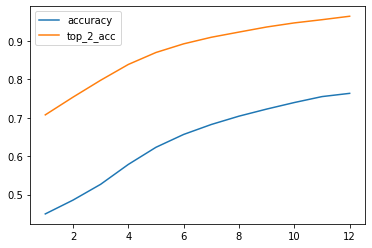

In [ ]:
for key in ['accuracy', 'top_2_acc']:
  plt.plot(range(1, len(feature_column_names)+1), accs[key], label = key)
plt.legend()
plt.show()

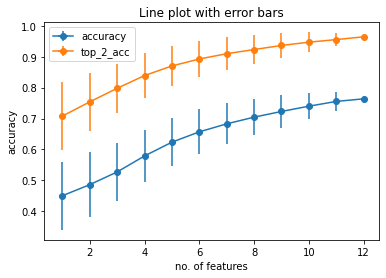

In [ ]:
fig, ax = plt.subplots()

for key in ['accuracy', 'top_2_acc']:
  ax.errorbar(range(1, len(feature_column_names)+1), accs[key],
              xerr=stds[key],
              yerr=stds[key],
              fmt='-o', label=key)

ax.legend()
ax.set_xlabel('no. of features')
ax.set_ylabel('accuracy')
ax.set_title('Line plot with error bars')
fig.savefig('/content/gdrive/MyDrive/images/acc_t2acc.png', dpi=600)

In [ ]:
cl_res=dict()
cl_std=dict()
for cl in classes:
  cl_res[cl]=dict()
  cl_std[cl]=dict()
  for key in ['f1-score', 'precision', 'recall', 'support']:
    # print('\n', key, ": ")
    cl_res[cl][key]=[]
    cl_std[cl][key]=[]
    for i in range(len(feature_column_names)):
      arr=[x[cl][key] for x in res[i].values()]
      cl_res[cl][key].append(np.mean(arr))
      cl_std[cl][key].append(np.std(arr))
      # print(i+1, "features: ", round(np.mean(arr), 6), u"\u00B1", round(np.std(arr), 6))

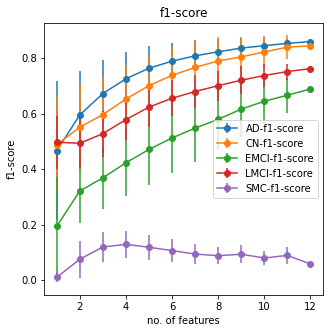

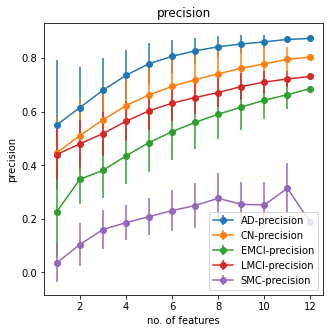

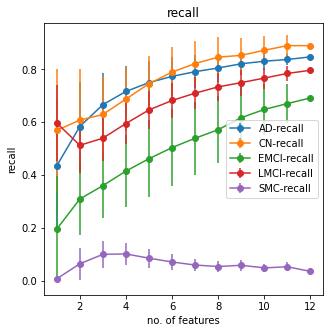

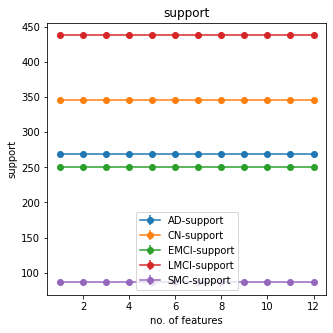

In [ ]:
for key in ['f1-score', 'precision', 'recall', 'support']:
  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  for cl in classes:
    ax.errorbar(range(1, len(feature_column_names)+1), cl_res[cl][key],
                yerr=cl_std[cl][key],
                fmt='-o', label=cl+'-'+key)
  fig.savefig('/content/gdrive/MyDrive/images/'+key+'.png', dpi=600)

  ax.legend()
  ax.set_xlabel('no. of features')
  ax.set_ylabel(key)
  ax.set_title(key)

In [ ]:
# top 2 graphs
t2_res=dict()
t2_std=dict()

for key in ['top_2_pr', 'top_2_re']:
  # print('\n', key, ": ")
  t2_res[key]=dict()
  t2_std[key]=dict()
  for cl in classes:
    t2_res[key][cl]=[]
    t2_std[key][cl]=[]
    for i in range(len(feature_column_names)):
      arr=[x[key][cl] for x in res[i].values()]
      t2_res[key][cl].append(np.mean(arr))
      t2_std[key][cl].append(np.std(arr))
    # print(i+1, "features: ", round(np.mean(arr), 6), u"\u00B1", round(np.std(arr), 6))

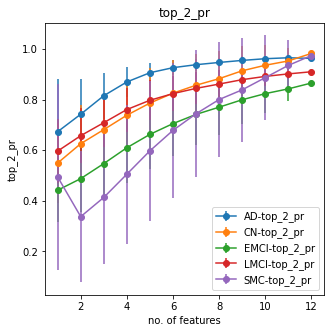

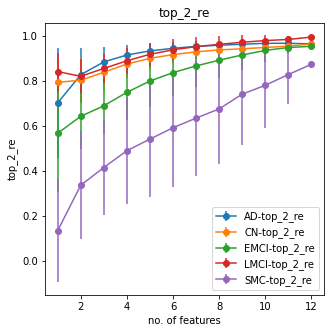

In [ ]:
for key in ['top_2_pr', 'top_2_re']:
  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  for cl in classes:
    ax.errorbar(range(1, len(feature_column_names)+1), t2_res[key][cl],
                yerr=t2_std[key][cl],
                fmt='-o', label=cl+'-'+key)
  fig.savefig('/content/gdrive/MyDrive/images/'+key+'.png', dpi=600)

  ax.legend()
  ax.set_xlabel('no. of features')
  ax.set_ylabel(key)
  ax.set_title(key)

In [ ]:
ftrs=['CDRSB_bl','MMSE_bl', 'MOCA_bl', 'ADAS13_bl', 'FAQ_bl', 'ADAS11_bl',
      'AGE', 'RAVLT_immediate_bl', 'RAVLT_perc_forgetting_bl', 'RAVLT_learning_bl',
      'PTEDUCAT', 'RAVLT_forgetting_bl' ]
accuracies_ftrs=[]
for i in  range(len(ftrs)):
  sub_ftrs=ftrs[:(i+1)]
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  X_cols=sub_ftrs
  y_col='DX_bl'
  X = np.array(train_df[X_cols])
  y = np.array(train_df[y_col])
  accs=cross_val_score(clf, X, y, cv=3)
  print(i+1, 'features, accuracies =', accs)
  accuracies_ftrs.append(accs)

1 features, accuracies = [0.63282937 0.66738661 0.68898488]
2 features, accuracies = [0.67602592 0.71706263 0.69978402]
3 features, accuracies = [0.73434125 0.77105832 0.76889849]
4 features, accuracies = [0.73866091 0.73434125 0.73650108]
5 features, accuracies = [0.72786177 0.74298056 0.75593952]
6 features, accuracies = [0.75161987 0.74514039 0.76673866]
7 features, accuracies = [0.74946004 0.76673866 0.78401728]
8 features, accuracies = [0.75593952 0.77105832 0.77105832]
9 features, accuracies = [0.76241901 0.76673866 0.75809935]
10 features, accuracies = [0.76025918 0.76889849 0.76673866]
11 features, accuracies = [0.75593952 0.77321814 0.77321814]
12 features, accuracies = [0.74946004 0.76457883 0.76673866]


Text(0.5, 1.0, 'ablation')

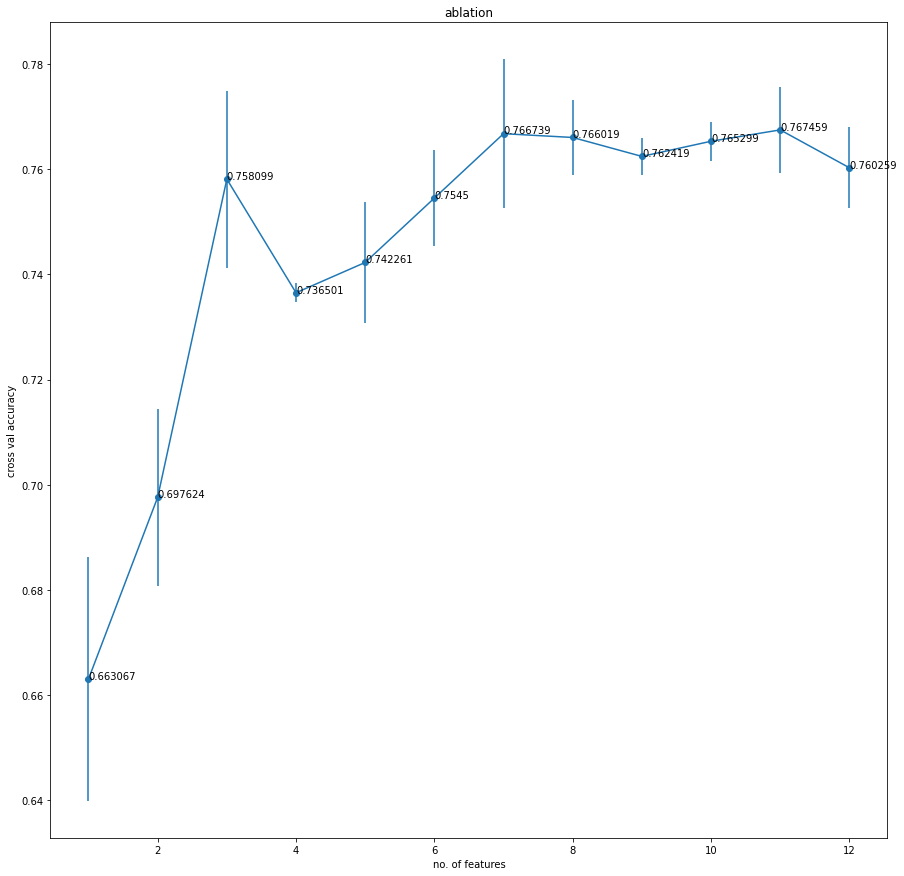

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

ax.errorbar(range(1, 13), [np.mean(acc) for acc in accuracies_ftrs],
            yerr=[np.std(acc) for acc in accuracies_ftrs],
            fmt='-o')
for a,b in zip(range(1, 13), [np.mean(acc) for acc in accuracies_ftrs]):
  ax.text(a, b, str(round(b,6)))
fig.savefig('/content/gdrive/MyDrive/images/ablation.png', dpi=600)


ax.set_xlabel('no. of features')
ax.set_ylabel('cross val accuracy')
ax.set_title('ablation')

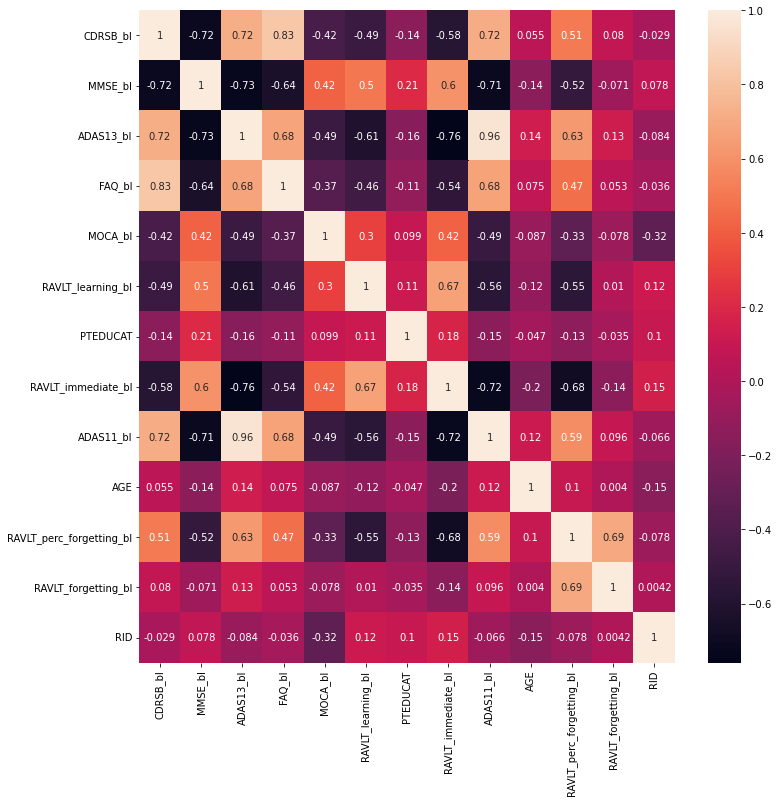

In [ ]:
corrMatrix=train_df.corr()
plt.figure(figsize=(12, 12))

sns.heatmap(corrMatrix, annot=True)
plt.savefig('/content/gdrive/MyDrive/images/heatmap.png', dpi=600)

In [ ]:
# file_path='/content/gdrive/MyDrive/Temporal_Data.csv'
# df = pd.read_csv(file_path)
# df = df[df.VISCODE=='bl']
# df.drop_duplicates()
# feature_column_names = ['CDRSB_bl', 'MMSE_bl', 'FAQ_bl', 'MOCA_bl', 'RAVLT_learning_bl', 'PTEDUCAT', 'RAVLT_immediate_bl' , 'ADAS11_bl', 'AGE', 'RAVLT_perc_forgetting_bl']
# predicted_class_names = ['DX_bl']
# other_columns = ['RID', 'VISCODE']
# fields = feature_column_names + predicted_class_names+other_columns

# df = get_df(df, method='mode', columns=fields)
# train_df, test_df, X_train, y_train, X_test, y_test = tt_split(df, feature_column_names, predicted_class_names[0])

# labels = np.array(train_df[predicted_class_names[0]])
# features = train_df.drop(predicted_class_names+other_columns, axis=1)
# feature_list = list(features.columns)
# features = np.array(features)
# classes=np.array(sorted(list(set(labels))))


CDRSB_bl
MMSE_bl
FAQ_bl
MOCA_bl
RAVLT_learning_bl
PTEDUCAT
RAVLT_immediate_bl
ADAS11_bl
AGE
RAVLT_perc_forgetting_bl
DX_bl
RID
VISCODE


In [ ]:
# rfc=RandomForestClassifier(random_state=42)
# param_grid = {
#     'n_estimators': [50,100],
#     'max_features': ['auto', 'log2'],
#     'max_depth' : [2,3,4,5,6,7,8,9,10],
#     'criterion' :['gini', 'entropy']
# }
# def tt_split(df, test_size=0.2,X_cols=None, y_col=None):
#   train_df, test_df = train_test_split(df, test_size=test_size)
#   X_train = np.array(train_df[X_cols])
#   y_train = np.array(train_df[y_col])
#   X_test = np.array(test_df[X_cols])
#   y_test = np.array(test_df[y_col])
#   return train_df, test_df, X_train, y_train, X_test, y_test
# # train1_df, val_df, X_train1, y_train1, X_val, y_val = tt_split(train_df, val_size, X_cols, y_col)
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)
# print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}


In [ ]:
# len(X_train), len(y_train)

(1389, 1389)

In [ ]:
# rf = RandomForestClassifier(**CV_rfc.best_params_, random_state=1)
# rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=1)

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# ## Preprocess training and test target (y) after having performed train-test split
# le = LabelEncoder()
# y_multi_train = pd.Series(le.fit_transform(y_train))
# y_multi_test = pd.Series(le.transform(y_test))

# ## Check classes
# le.classes_

array(['AD', 'CN', 'EMCI', 'LMCI', 'SMC'], dtype=object)

In [ ]:

# ## Convert transformed (preprocessed) X train set into pandas DataFrame
# X_train_df = pd.DataFrame(X_train, columns=feature_column_names)

# ## Calculate SHAP values for model
# multi_explainer = shap.TreeExplainer(rf)
# multi_shap_values = multi_explainer.shap_values(X_train_df)

In [ ]:
# def multi_shap_force_le(clf, index,
#                         X_train_df, y_train,
#                         explainer, multi_shap_vals,
#                         le_classes,
#                         classes='both'):

#     """Takes in a fitted classifier Pipeline, the name of the classifier step,
#         the X training DataFrame, the y train array, a shap explainer, and the
#         multiclass shap values to print the ground truth and predicted label for
#         the record and display shap force plots of the desired classes
#         for the record specified by index.
#     Args:
#         clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
#         clf_step_name (str): The name given to the classifier step of the pipe.
#         index (int): The index of the observation of interest.
#         X_train_df (DataFrame): A Pandas DataFrame that from the train-test-split
#             used to train the classifier, with column names corresponding to
#             the feature names.
#         y_train (series or array): Subset of y data used for training.
#         explainer (shap explainer): A fitted shap.TreeExplainer object
#         multi_shap_vals (list): The list of arrays of shap values. One array per
#             target label.
#         le_classes (array): The classes_ attribute of the label encoded target variable.
#         classes (str, optional): A string specifying which shap force plots
#             to display for the specified record. Options are 'all' (displays for all
#             class labels), 'true' (displays only the plot for the ground truth label for
#             the record), 'pred' (displays only the plot for the predicted label for
#             the record), or 'both' (displays both 'true' and 'pred'). Defaults to 'both'.
#     """

#     ## Create dict for mapping class labels
#     label_dict = {}
#     for i, label in list(enumerate(le_classes)):
#         label_dict[i] = label

#     ## Store model prediction and ground truth label for that index
#     pred = int(clf.predict(X_train_df.iloc[index,:]))
#     true_label = pd.Series(y_train).iloc[index]


#     ## Assess accuracy of prediction
#     if true_label == pred:
#         accurate = 'Correct!'
#     else:
#         accurate = 'Incorrect'


#     ## Print output that checks model's prediction against true label
#     print('***'*17)
#     # Print ground truth label for row at index
#     print(f'Ground Truth Label: {true_label} - {label_dict[true_label]}')
#     print()
#     # Print model prediction for row at index
#     print(f'Model Prediction:  [{pred}] - {label_dict[pred]} -- {accurate}')
#     print('***'*17)
#     print()
#     print()


#     ## Determine which classes to show force plots for
#     # All classes
#     if classes == 'all':
#         ## Visualize the ith prediction's explanation for all classes
#         for key in range(len(label_dict)):
#             print(f'{label_dict[key]} Class ({key})')
#             display(shap.force_plot(explainer.expected_value[key],
#                         multi_shap_vals[key][index],
#                         X_train_df.iloc[index,:]))
#             print()


#     # Only the class predicted by the model
#     elif classes == 'pred':
#         print(f'Predicted: {label_dict[pred]} Class {pred}')
#         display(shap.force_plot(explainer.expected_value[pred],
#                                 multi_shap_vals[pred][index],
#                                 X_train_df.iloc[index,:]))


#     # Only the ground truth label
#     elif classes == 'true':
#         print(f'True: {label_dict[true_label]} Class {true_label}')
#         display(shap.force_plot(explainer.expected_value[true_label],
#                     multi_shap_vals[true_label][index],
#                     X_train_df.iloc[index,:]))


#     # Both the predicted and ground truth (identical plots if prediction is correct)
#     elif classes == 'both':
#         print(f'Predicted: {label_dict[pred]} Class {pred}')
#         display(shap.force_plot(explainer.expected_value[pred],
#                                 multi_shap_vals[pred][index],
#                                 X_train_df.iloc[index,:]))
#         print()

#         print(f'True: {label_dict[true_label]} Class {true_label}')
#         display(shap.force_plot(explainer.expected_value[true_label],
#                     multi_shap_vals[true_label][index],
#                     X_train_df.iloc[index,:]))

In [ ]:
# explainer_ebm = shap.Explainer(rf.predict, X_train)
# shap_values_ebm = explainer_ebm(X_train)
# shap.plots.beeswarm(shap_values_ebm, max_display=14)


ValueError: ignored

1.   XGBoost: \
learning rate: [0.1, 0.5, 1]\
n-estimator  : [50, 100]\
max-depth    : [1,2,3,4,5,6]

2.   Random Forest: \
n-estimator: [50, 100] \
max-depth:   [1,2,3,4,5,6,7,8,9,10] \
min-samples-split: [2, 3, 4] \
max-features: [3,4,5,6,7,8,9,10]

<!-- 3. Feature Importance - XGB, RF - Global -->
4. SHAP Summary Plot - XGB, RF - all classes, specific class - Global
<!-- 5. SHAP Waterfall Plot - XGB, RF - Local -->
5. LIME Local Explainability

6. [Top-1, Top-2] - [Acc (o),  Re (co),  Pr,(co) F1-score (o)] - [3, 5]


Note: 3 class experiments performed by modiyfing the data to 3 class setting
